In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory

import os
print(os.listdir("../input"))

# Any results you write to the current directory are saved as output.

['mnist_train.csv', 'mnist_test.csv']


Alex Towers 1105233

In [2]:
train = pd.read_csv("../input/mnist_train.csv", dtype=int)
test = pd.read_csv("../input/mnist_test.csv", dtype=int)
X_train = train.drop('label', axis=1)
y_train = train['label']
X_test = test.drop('label', axis=1)
y_test = test['label']

In [3]:
import warnings
warnings.filterwarnings('ignore')

In [4]:
from sklearn.ensemble import ExtraTreesClassifier
et_clf = ExtraTreesClassifier()

In [5]:
def best_depth(CLF, X_train, y_train):
    highest_score=0
    for depth in range(10, 61, 10):
        CLF = ExtraTreesClassifier(max_depth=depth, n_estimators = 300, oob_score=True, bootstrap=True, random_state=1105233, n_jobs=-1)
        CLF.fit(X_train, y_train)
        oob_score = CLF.oob_score_
        print(depth, oob_score)
        if(oob_score > highest_score):
            highest_score = oob_score
            max_depth = depth
            result = [highest_score, max_depth]
    return result
    

In [6]:
best = best_depth(et_clf, X_train, y_train)
print(best)

10 0.9375833333333333
20 0.9672333333333333
30 0.9693
40 0.96925
50 0.9692666666666667
60 0.96925
[0.9693, 30]


In [7]:
et_clf=ExtraTreesClassifier(max_depth=30, n_estimators = 300, oob_score=True, bootstrap=True, random_state=1105233, n_jobs=-1)
et_clf.fit(X_train, y_train)
pred = et_clf.predict(X_test)


In [8]:
from sklearn.metrics import accuracy_score
accuracy = accuracy_score(y_test, pred)
print(accuracy)

0.9702


In [9]:
et_decision_func = et_clf.oob_decision_function_
et_best_clf_proba = et_clf.predict_proba(X_test)

In [10]:
def single_extra_tree(depth=None, seed=1105233):
    return ExtraTreesClassifier(max_depth=depth, n_estimators=1, bootstrap=False, random_state=seed)

In [11]:
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import BaggingClassifier


In [12]:
for depth in range(10,61,10):
    highest_score=0
    boost = AdaBoostClassifier(base_estimator=single_extra_tree(depth=depth), n_estimators=10, random_state=1105233)
    bag = BaggingClassifier(base_estimator=boost, n_estimators=30, bootstrap=True, oob_score=True, n_jobs=-1, random_state=42)
    bag.fit(X_train, y_train)
    oob_score = bag.oob_score_
    print(depth, oob_score)
    if(oob_score > highest_score):
        highest_score = oob_score
        max_depth = depth
        result = [highest_score, max_depth]
print(result)
    

10 0.9487166666666667
20 0.9613333333333334
30 0.9648166666666667
40 0.9492333333333334
50 0.9453166666666667
60 0.9446166666666667
[0.9446166666666667, 60]


In [13]:
boost = AdaBoostClassifier(base_estimator=single_extra_tree(depth=60), n_estimators=10, random_state=1105233)
bag = BaggingClassifier(base_estimator=boost, n_estimators=30, bootstrap=True, oob_score=True, n_jobs=-1, random_state=42)
bag.fit(X_train, y_train)
bag_pred = bag.predict(X_test)
print(accuracy_score(y_test, bag_pred))

0.9641


In [14]:
bag_decision_func = bag.oob_decision_function_
bag_best_clf_proba = bag.predict_proba(X_test)

In [15]:
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline
pip_highest_score=0
for num_components in (20,40,60):
    pca = PCA(n_components=num_components, svd_solver='randomized', random_state=1105233)
    pip = Pipeline( [ ('pca', pca),
                ('ada_xt', AdaBoostClassifier(base_estimator=single_extra_tree(depth=10), n_estimators=10, random_state=42))])
    pip_bag = BaggingClassifier(base_estimator=pip, n_estimators=30, bootstrap=True, oob_score=True, n_jobs=-1, random_state=42)
    pip_bag.fit(X_train, y_train)
    oob_score = bag.oob_score_
    print(num_components, oob_score)
    if(oob_score > pip_highest_score):
        pip_highest_score = oob_score
        components = num_components
        result = [pip_highest_score, components]
print(result)

20 0.9446166666666667
40 0.9446166666666667
60 0.9446166666666667
[0.9446166666666667, 20]


In [16]:
pca = PCA(n_components=20, svd_solver='randomized', random_state=1105233)
pip = Pipeline( [ ('pca', pca),
              ('ada_xt', AdaBoostClassifier(base_estimator=single_extra_tree(depth=10), n_estimators=10, random_state=42))])
pip_bag = BaggingClassifier(base_estimator=pip, n_estimators=30, bootstrap=True, oob_score=True, n_jobs=-1, random_state=42)
pip_bag.fit(X_train, y_train)
pip_bag_pred=pip_bag.predict(X_test)
print(accuracy_score(y_test, pip_bag_pred))

0.9432


In [17]:
bag_pip_decision_func = pip_bag.oob_decision_function_
bag_pip_best_clf_proba = pip_bag.predict_proba(X_test)

In [18]:
C123 = np.sum( [et_decision_func, bag_decision_func, bag_pip_decision_func], axis=0)
#C123_accuracy = accuracy_score(y_test, np.where(C123 == np.argmax(C123)))

In [19]:
C0 = np.sum( [et_decision_func], axis=0)
C1 = np.sum( [bag_decision_func], axis=0)
C2 = np.sum( [bag_pip_decision_func], axis=0)
C3 = np.sum( [et_decision_func, bag_decision_func], axis=0)
C4 = np.sum( [et_decision_func, bag_pip_decision_func], axis=0)
C5 = np.sum( [bag_decision_func, bag_pip_decision_func], axis=0)
C6 = np.sum( [et_decision_func, bag_decision_func, bag_pip_decision_func], axis=0)

for score in (C0, C1, C2, C3, C4, C5, C6):
    print(accuracy_score(y_train,  np.argmax(score, axis=1)))

0.9693
0.9446333333333333
0.9282166666666667
0.9641166666666666
0.95995
0.9545833333333333
0.9633333333333334


In [20]:
from sklearn.ensemble import VotingClassifier
et = CLF = ExtraTreesClassifier(max_depth=30, n_estimators = 300, oob_score=True, bootstrap=True, random_state=1105233, n_jobs=-1)
voting_clf = VotingClassifier(estimators=[('et', et_clf)], voting='soft')
voting_clf.fit(X_train, y_train)
vot_pred = voting_clf.predict(X_test)
vot_score = accuracy_score(y_test, vot_pred)

In [21]:
print(vot_score)

0.9702


In [22]:
X_train_meta = np.concatenate( [et_decision_func, bag_decision_func, bag_pip_decision_func], axis=1)
X_test_meta = np.concatenate( [et_best_clf_proba, bag_best_clf_proba, bag_pip_best_clf_proba], axis=1)

In [94]:
from sklearn.linear_model import LogisticRegression
lr = LogisticRegression(random_state=1105233, C=50, n_jobs=-1)

lr.fit(X_train_meta, y_train)
lr_pred = lr.predict(X_test_meta)
lr_pred_proba = lr.predict_proba(X_test_meta)
lr_accuracy = accuracy_score(y_test, lr_pred)
print(lr_accuracy)

0.9725


Logistic regression accuracy score was 97%. Logistic regression is slightly better than voting although my voting_clf only used one classifier so it wasn't really true voting

In [95]:
for i in range(len(lr_pred)):
    if(lr_pred[i] != y_test[i]):
        print("Predicted ", lr_pred[i], " but was ", y_test[i], " at index ", i)

Predicted  8  but was  2  at index  149
Predicted  8  but was  9  at index  241
Predicted  2  but was  4  at index  247
Predicted  0  but was  6  at index  259
Predicted  7  but was  9  at index  320
Predicted  7  but was  2  at index  321
Predicted  3  but was  5  at index  340
Predicted  4  but was  6  at index  341
Predicted  7  but was  3  at index  381
Predicted  9  but was  8  at index  403
Predicted  0  but was  6  at index  445
Predicted  8  but was  9  at index  448
Predicted  5  but was  3  at index  449
Predicted  0  but was  8  at index  495
Predicted  3  but was  8  at index  543
Predicted  3  but was  7  at index  551
Predicted  2  but was  8  at index  582
Predicted  8  but was  2  at index  613
Predicted  7  but was  2  at index  659
Predicted  3  but was  7  at index  684
Predicted  9  but was  4  at index  707
Predicted  6  but was  0  at index  717
Predicted  8  but was  5  at index  720
Predicted  9  but was  4  at index  740
Predicted  3  but was  8  at index  839


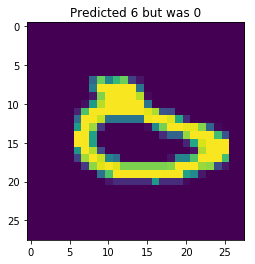

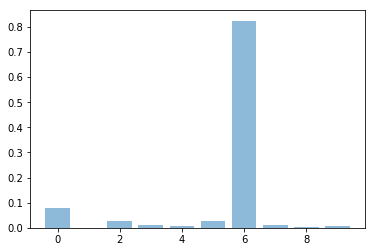

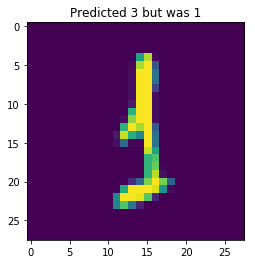

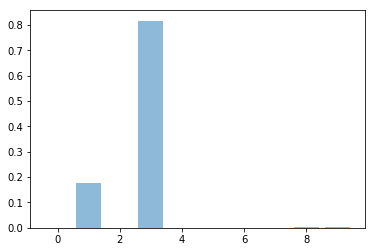

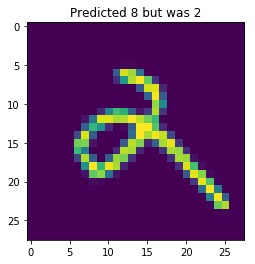

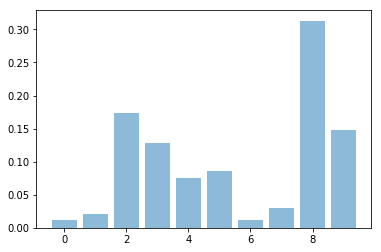

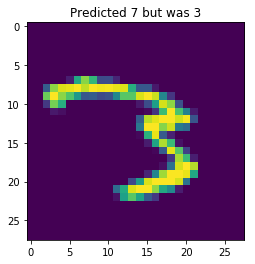

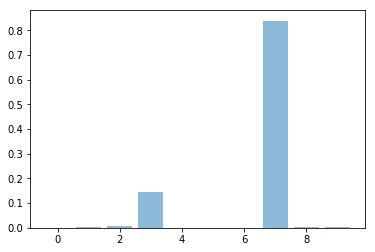

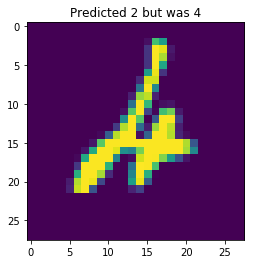

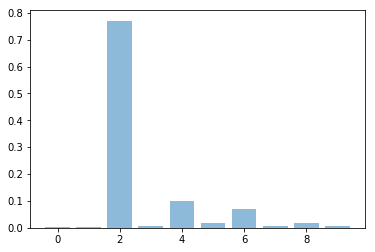

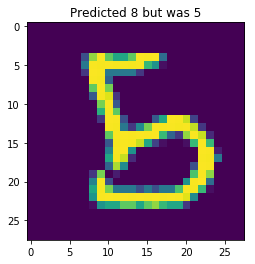

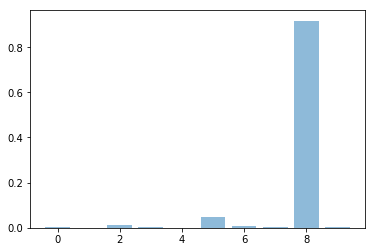

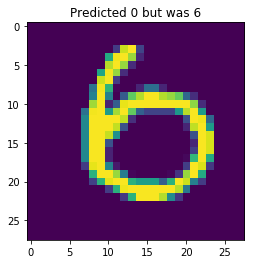

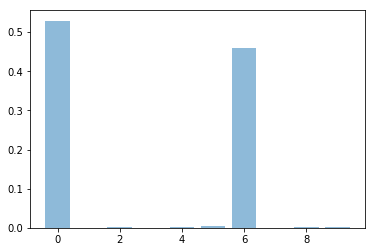

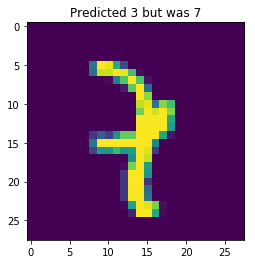

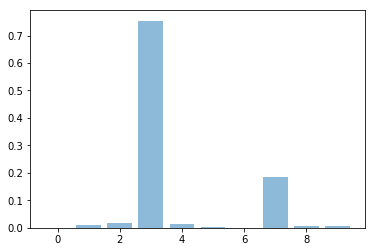

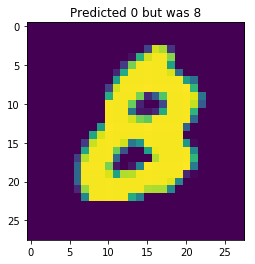

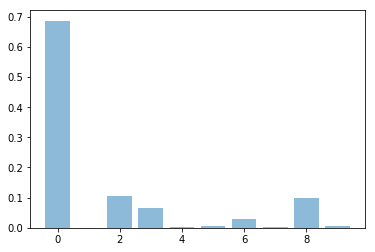

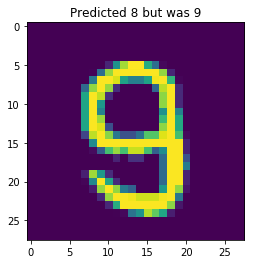

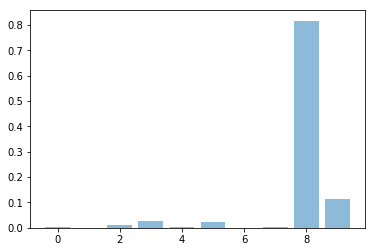

In [110]:
import matplotlib.pyplot as plt
plot0 = X_test.iloc[717].values.reshape(28,28)
plot1 = X_test.iloc[900].values.reshape(28,28)
plot2 = X_test.iloc[149].values.reshape(28,28)
plot3 = X_test.iloc[381].values.reshape(28,28)
plot4 = X_test.iloc[247].values.reshape(28,28)
plot5 = X_test.iloc[720].values.reshape(28,28)
plot6 = X_test.iloc[259].values.reshape(28,28)
plot7 = X_test.iloc[551].values.reshape(28,28)
plot8 = X_test.iloc[495].values.reshape(28,28)
plot9 = X_test.iloc[241].values.reshape(28,28)

classes = (0, 1, 2, 3, 4, 5, 6, 7, 8, 9)
y_pos = np.arange(len(classes))

plt.imshow(plot0)
plt.title("Predicted 6 but was 0")
plt.show()
plt.bar(y_pos, lr_pred_proba[717], align='center', alpha=0.5)
plt.show()
plt.imshow(plot1)
plt.title("Predicted 3 but was 1")
plt.show()
plt.bar(y_pos, lr_pred_proba[900], align='center', alpha=0.5)
plt.show()
plt.imshow(plot2)
plt.title("Predicted 8 but was 2")
plt.show()
plt.bar(y_pos, lr_pred_proba[149], align='center', alpha=0.5)
plt.show()
plt.imshow(plot3)
plt.title("Predicted 7 but was 3")
plt.show()
plt.bar(y_pos, lr_pred_proba[381], align='center', alpha=0.5)
plt.show()
plt.imshow(plot4)
plt.title("Predicted 2 but was 4")
plt.show()
plt.bar(y_pos, lr_pred_proba[247], align='center', alpha=0.5)
plt.show()
plt.imshow(plot5)
plt.title("Predicted 8 but was 5")
plt.show()
plt.bar(y_pos, lr_pred_proba[720], align='center', alpha=0.5)
plt.show()
plt.imshow(plot6)
plt.title("Predicted 0 but was 6")
plt.show()
plt.bar(y_pos, lr_pred_proba[259], align='center', alpha=0.5)
plt.show()
plt.imshow(plot7)
plt.title("Predicted 3 but was 7")
plt.show()
plt.bar(y_pos, lr_pred_proba[551], align='center', alpha=0.5)
plt.show()
plt.imshow(plot8)
plt.title("Predicted 0 but was 8")
plt.show()
plt.bar(y_pos, lr_pred_proba[495], align='center', alpha=0.5)
plt.show()
plt.imshow(plot9)
plt.title("Predicted 8 but was 9")
plt.show()
plt.bar(y_pos, lr_pred_proba[241], align='center', alpha=0.5)
plt.show()


[3.38446468e-04 5.70825218e-04 5.22809649e-04 1.97346407e-03
 1.67301584e-04 7.87357639e-04 1.20040387e-04 9.94821175e-01
 4.72965852e-04 2.25613860e-04]
